# Assignment 1

Mathia Quimpo, Matthew Chin, Wanqiu Zhang

## Exploration and Preprocessing

In [1]:
import pandas as pd
import numpy as np
import re
import os
import string
import nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import matplotlib.pyplot as plt

In [5]:
# Download necessary resources
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\matth\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\matth\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\matth\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\matth\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# Load dataset
file_path = os.path.expanduser("~/Desktop/School/6200/Project/Reviews.csv")  
df = pd.read_csv(file_path)

print(df.head())

   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1 

In [3]:
# Display column names
print("Columns in the dataset:\n", df.columns)

Columns in the dataset:
 Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')


In [4]:
# Get general info
print(df.info())

# Descriptive statistics
print(df.describe())

# Check for missing values
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB
None
                  Id  HelpfulnessNumerator  HelpfulnessDenominator  \
count  568454.000000         568454.000000            568454.00000   
mean   284227.500000              1.743817               

In [5]:
# Display the entire review text 
pd.set_option('display.max_colwidth', None)

In [6]:
# Add a new column for text length
df["Text_Length"] = df["Text"].astype(str).apply(len)

# Display descriptive statistics for text length
print(df["Text_Length"].describe())

count    568454.000000
mean        436.222083
std         445.339741
min          12.000000
25%         179.000000
50%         302.000000
75%         527.000000
max       21409.000000
Name: Text_Length, dtype: float64


In [7]:
# Read a few random review samples
print(df["Text"].sample(10, random_state=45))

300665                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        I have used this product before and found it to be the best product for jerk chicken. I could not find this product anywhere until my sister suggested I look on Amazon. There is nothing like it. It has a very unique taste.  I have tried other products out there and nothing compares to Busha Brownes Authentic Jerk Seasoning. I find myself wanting to go to jamaica and drink some rum and have jerk chicken.
167

In [8]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

In [10]:
# Text cleaning function
def clean_text(text):
    if not isinstance(text, str):
        return ""  # Handle missing values
    
    # 1. Remove HTML tags using a regex pattern
    text = re.sub(r"<.*?>", "", text)  # Remove HTML tags

    # 2. Replace URLs with a placeholder "URL"
    text = re.sub(r'http[s]?://\S+', 'URL', text)

    # 3. Convert to lowercase
    text = text.lower()

    # 4. Normalize whitespace (remove any leftover <br /> or extra spaces)
    text = re.sub(r"\s+", " ", text).strip()

    # 5. Remove special characters, numbers, and punctuation
    text = re.sub(r"[^a-z\s]", "", text)

    # 6. Tokenize the text into words
    words = word_tokenize(text)

    # 7. Remove stopwords
    words = [word for word in words if word not in stop_words]
    
    # 8. Lemmatize the tokens
    cleaned_text = [lemmatizer.lemmatize(word) for word in words]

    # 9. Replace multiple spaces with a single space
    cleaned_text = " ".join(cleaned_text)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()

    return cleaned_text

In [11]:
# Select 100 random rows
random_sample = df.sample(100)

In [12]:
# Apply the updated cleaning function to the Text column
random_sample["Cleaned_Text"] = random_sample["Text"].apply(clean_text)

In [13]:
# Spot-checking
spotcheck_sample = random_sample[["Text", "Cleaned_Text"]].sample(5, random_state=45)
print(spotcheck_sample)

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             Text  \
113989                                                                                                                             

## VADER

In [14]:
# Initialize VADER Sentiment Analyzer
analyzer = SentimentIntensityAnalyzer()

In [17]:
# Add negative words or phrases
custom_lexicon = {
    "meh": -0.5,
    "could be better": -0.3,
    "not great": -0.6,
    "disappointed": -0.8,
    "not happy": -0.7,
    "good product": 0.6,
    "love it": 0.8,
    "great taste": 0.7,
    "highly recommend": 0.9,
    "would buy again": 0.7,
    "favorite": 0.8,
    "best product": 0.9,
    "delicious": 0.8,
    "wonderful": 0.75,
    "impressed": 0.7,
    "good quality": 0.7,
    "pleasantly surprised": 0.6,
    "better than expected": 0.7,
    "amazing": 0.9,
    "perfect": 1.0,
    "satisfied": 0.6,
    "tasty": 0.7,
    "excited to try": 0.7,
    "nice texture": 0.6,
    "will buy again": 0.7
}

# Extend the lexicon
analyzer.lexicon.update(custom_lexicon)

In [18]:
# Tokenize the Cleaned_Text once and store it in a new column 'Tokens'
random_sample['Tokens'] = random_sample['Cleaned_Text'].apply(word_tokenize)

In [19]:
# Apply Feature Engineering on the pre-tokenized text
def extract_features_from_tokens(tokens):
    word_count = len(tokens)
    unique_word_count = len(set(tokens))
    avg_word_length = sum(len(word) for word in tokens) / word_count if word_count else 0

    # Sentiment analysis with VADER
    sentiment = analyzer.polarity_scores(" ".join(tokens))  # VADER expects a string, not tokens

    return [word_count, unique_word_count, avg_word_length, sentiment['compound']]

# Now apply the feature extraction on the 'Tokens' column (pre-tokenized)
random_sample[['Word_Count', 'Unique_Word_Count', 'Avg_Word_Length', 'Sentiment_Score']] = random_sample['Tokens'].apply(
    lambda x: pd.Series(extract_features_from_tokens(x)))

# Spot-check the results
print(random_sample[['Text', 'Cleaned_Text', 'Tokens', 'Word_Count', 'Unique_Word_Count', 'Avg_Word_Length', 'Sentiment_Score']].head())


                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             Text  \
113989  This is a good tasting snack, but I should have read the reviews more carefully.  It's called "Cherry Berry" but it should be called "Apple Cherry Berry with more Apples and some Apples on top".  The apples are fine, but I expected more berries.<br /><br />Also, I don't know if this is an effect of shipping or what, but there's a lot of "fruit dust" in the bottom. Be careful if you tip the package up over your mouth (which you will do since your hand does

In [20]:
def classify_sentiment(sentiment_score):
    if sentiment_score > 0.1:
        return "Positive"
    elif sentiment_score < -0.1:
        return "Negative"
    else:
        return "Neutral"

# Apply sentiment classification based on VADER sentiment score
random_sample['Sentiment_Label'] = random_sample['Sentiment_Score'].apply(classify_sentiment)

# Show some of the classified sentiments
print(random_sample[['Cleaned_Text', 'Sentiment_Score', 'Sentiment_Label']].head())

                                                                                                                                                                                                                                                                   Cleaned_Text  \
113989  good tasting snack read review carefully called cherry berry called apple cherry berry apple apple top apple fine expected berriesalso dont know effect shipping there lot fruit dust bottom careful tip package mouth since hand doesnt fit narrow package easy inhale   
39340                                                                                                                                                                                                                         bought daughter canning apple slice delighted get   
195763                                                three cat two wanted nothing matter many time tried ended pooping carpet something never done beforethe cat us litterbox 

In [21]:
# Extract sentiment predictions from VADER
random_sample['VADER_Sentiment'] = random_sample['Sentiment_Score'].apply(
    lambda score: 'Positive' if score > 0 else 'Negative' if score < 0 else 'Neutral'
)

In [22]:
# Spot-check several examples
spotcheck_sample = random_sample[['Text', 'VADER_Sentiment']].sample(5, random_state=45)

print(spotcheck_sample)

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             Text  \
113989                                                                                                                             

In [23]:
# To manually review the sentiment, you can check the first few examples
for idx, row in spotcheck_sample.iterrows():
    print(f"Review Text: {row['Text']}")
    print(f"VADER Sentiment: {row['VADER_Sentiment']}")
    print("-" * 50)

Review Text: This is a good tasting snack, but I should have read the reviews more carefully.  It's called "Cherry Berry" but it should be called "Apple Cherry Berry with more Apples and some Apples on top".  The apples are fine, but I expected more berries.<br /><br />Also, I don't know if this is an effect of shipping or what, but there's a lot of "fruit dust" in the bottom. Be careful if you tip the package up over your mouth (which you will do since your hand doesn't fit in the narrow package) because it's easy to inhale it.
VADER Sentiment: Positive
--------------------------------------------------
Review Text: I bought these for my daughter to do some canning with apple slices & she was delighted to get them
VADER Sentiment: Positive
--------------------------------------------------
Review Text: I've been giving my daughter Gerber fruits, veggies, and meat as everyday-meals since she was 6 months old, thinking that she's got enough vitamins and prebiotics. However, she develope

## TextBlob

In [24]:
def analyze_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity, 'Positive' if blob.sentiment.polarity > 0 else ('Negative' if blob.sentiment.polarity < 0 else 'Neutral')

# Apply the function and append new columns
random_sample[['TextBlob_Polarity', 'TextBlob_Subjectivity', 'TextBlob_Sentiment']] = random_sample['Cleaned_Text'].apply(lambda x: pd.Series(analyze_sentiment(x)))

# Display the updated DataFrame
random_sample

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,...,Tokens,Word_Count,Unique_Word_Count,Avg_Word_Length,Sentiment_Score,Sentiment_Label,VADER_Sentiment,TextBlob_Polarity,TextBlob_Subjectivity,TextBlob_Sentiment
113989,113990,B000EYRHL2,AUH81IUWU4RFP,EAC,2,3,3,1215475200,"Tastes good, but Don't Inhale","This is a good tasting snack, but I should have read the reviews more carefully. It's called ""Cherry Berry"" but it should be called ""Apple Cherry Berry with more Apples and some Apples on top"". The apples are fine, but I expected more berries.<br /><br />Also, I don't know if this is an effect of shipping or what, but there's a lot of ""fruit dust"" in the bottom. Be careful if you tip the package up over your mouth (which you will do since your hand doesn't fit in the narrow package) because it's easy to inhale it.",...,"[good, tasting, snack, read, review, carefully, called, cherry, berry, called, apple, cherry, berry, apple, apple, top, apple, fine, expected, berriesalso, dont, know, effect, shipping, there, lot, fruit, dust, bottom, careful, tip, package, mouth, since, hand, doesnt, fit, narrow, package, easy, inhale]",41.0,34.0,5.439024,0.8907,Positive,Positive,0.216667,0.625926,Positive
39340,39341,B003U4LUN4,A1D9MRUWGH1NV5,Karen L. Thomas,0,0,5,1342051200,red hots,I bought these for my daughter to do some canning with apple slices & she was delighted to get them,...,"[bought, daughter, canning, apple, slice, delighted, get]",7.0,7.0,6.142857,0.5106,Positive,Positive,0.700000,0.700000,Positive
195763,195764,B001E530FW,A2O8QF1THCP46H,"Ed from Austin ""Ed""",73,84,1,1211846400,"Had such great hopes, but......","We have three cats - two wanted nothing to do with it no matter how many times we tried. Ended up pooping on the carpet, something they have never done before.<br /><br />The other cat, who uses this litterbox, gets diahrea on a regular basis. The box is not designed for that type of mess! We ended up scooping most of the granules out.<br /><br />So if your cat has these type of issues, do not use!",...,"[three, cat, two, wanted, nothing, matter, many, time, tried, ended, pooping, carpet, something, never, done, beforethe, cat, us, litterbox, get, diahrea, regular, basis, box, designed, type, mess, ended, scooping, granule, outso, cat, type, issue, use]",35.0,31.0,5.228571,-0.3765,Negative,Negative,0.108333,0.250641,Positive
130506,130507,B001ELL6VG,A1O66CYSE9ZW0W,Chris Cardinal,0,0,5,1320019200,Best brownies I've had,"I've had a lot of brownies, both from mixes and homemade and I think these may be the best brownies I've ever had. The chocolate chips melt and create little pockets of amazing. They're perfectly chewy, high quality chocolate, and just the right amount of sweet. Absolutely amazing.",...,"[ive, lot, brownie, mix, homemade, think, may, best, brownie, ive, ever, chocolate, chip, melt, create, little, pocket, amazing, theyre, perfectly, chewy, high, quality, chocolate, right, amount, sweet, absolutely, amazing]",29.0,25.0,5.689655,0.9461,Positive,Positive,0.476027,0.665714,Positive
182243,182244,B005OSC218,AJZXTZ3I9A84H,Jeromy,1,1,5,1316995200,The Best,I've impressed so many of my friends by busting these out at parties we throw. They're way better than those cherries and everyone was asking me where I'd found them.,...,"[ive, impressed, many, friend, busting, party, throw, theyre, way, better, cherry, everyone, asking, id, found]",15.0,15.0,5.400000,0.8591,Positive,Positive,0.666667,0.666667,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153054,153055,B00141WDXG,A3AMDR3RZP1RQQ,Tim Groves,29,33,1,1258070400,reommend you avoid chinese sourced food products for your pet,"These chicken strips (and most others like them) are priced so low they are hard to resist. My dogs love them of course and for dogs who tolerate chicken, they should be excellent treats. However, I do not trust pet foods sourced from Ch

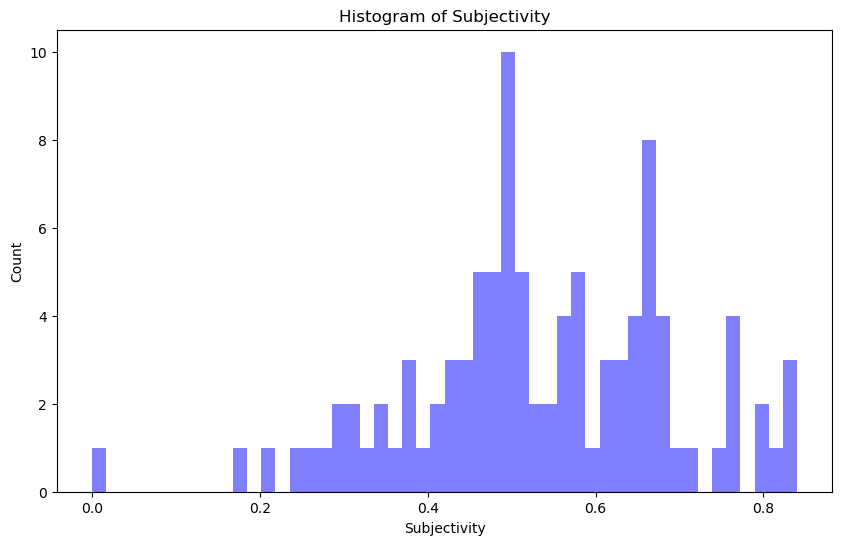

In [25]:
#Draw a histogram that shows the distribution of subjectivity: Count vs. subjectivity
num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(random_sample.TextBlob_Subjectivity, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Subjectivity')
plt.ylabel('Count')
plt.title('Histogram of Subjectivity')
plt.show()

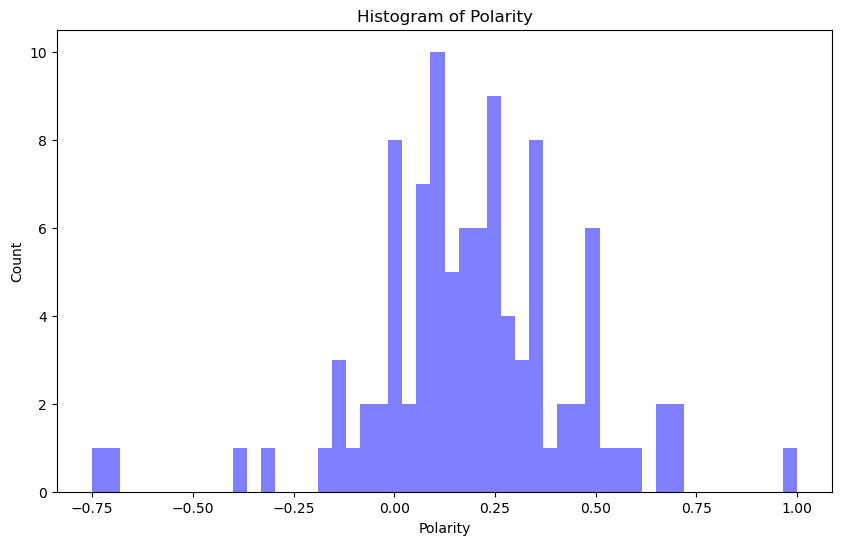

In [26]:
#Draw a histogram that shows the distribution of polarity: Count vs. polarity
num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(random_sample.TextBlob_Polarity, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.title('Histogram of Polarity')
plt.show()